In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plant-pathology-2021-fgvc8/sample_submission.csv
/kaggle/input/plant-pathology-2021-fgvc8/train.csv
/kaggle/input/plant-pathology-2021-fgvc8/train_images/a8d54d0d96517ab3.jpg
/kaggle/input/plant-pathology-2021-fgvc8/train_images/ac6902fd1f0f3ce0.jpg
/kaggle/input/plant-pathology-2021-fgvc8/train_images/d4b7ea94e1c509e2.jpg
/kaggle/input/plant-pathology-2021-fgvc8/train_images/c780633f9d9d2970.jpg
/kaggle/input/plant-pathology-2021-fgvc8/train_images/a506c47f0f2d3d61.jpg
/kaggle/input/plant-pathology-2021-fgvc8/train_images/d4d8689596df6b80.jpg
/kaggle/input/plant-pathology-2021-fgvc8/train_images/edd8cfc45e503252.jpg
/kaggle/input/plant-pathology-2021-fgvc8/train_images/9ab326c1951acb7a.jpg
/kaggle/input/plant-pathology-2021-fgvc8/train_images/f728e036d729a0ad.jpg
/kaggle/input/plant-pathology-2021-fgvc8/train_images/fce318c6518fd20e.jpg
/kaggle/input/plant-pathology-2021-fgvc8/train_images/ab89d542c8cb2dc7.jpg
/kaggle/input/plant-pathology-2021-fgvc8/train_images/fd014f4

In [2]:
os.listdir('/kaggle/input/plant-pathology-2021-fgvc8/')

['sample_submission.csv', 'train_images', 'train.csv', 'test_images']

In [3]:
import pandas as pd
import numpy as np
import os
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

plt.style.use('seaborn')
%matplotlib inline

In [4]:
train_df = pd.read_csv('/kaggle/input/plant-pathology-2021-fgvc8/train.csv')
test_df = pd.read_csv('/kaggle/input/plant-pathology-2021-fgvc8/sample_submission.csv')
print("Dataset Shape: ",train_df.shape)
train_df.head()

Dataset Shape:  (18632, 2)


,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [5]:
datapath = glob('/kaggle/input/plant-pathology-2021-fgvc8/train_images/*')
print("Image Datasets Shape: ", len(datapath))

Image Datasets Shape:  18632


In [6]:
def add_link(path):
    return_path ='/kaggle/input/plant-pathology-2021-fgvc8/train_images/'+str(path)
    return return_path

In [7]:
def add_link_test(path):
    return_path ='/kaggle/input/plant-pathology-2021-fgvc8/test_images/'+str(path)
    return return_path

In [8]:
train_df['image'] = train_df['image'].apply(lambda x: add_link(x))
train_df.head()

,image,labels
0,/kaggle/input/plant-pathology-2021-fgvc8/train...,healthy
1,/kaggle/input/plant-pathology-2021-fgvc8/train...,scab frog_eye_leaf_spot complex
2,/kaggle/input/plant-pathology-2021-fgvc8/train...,scab
3,/kaggle/input/plant-pathology-2021-fgvc8/train...,scab
4,/kaggle/input/plant-pathology-2021-fgvc8/train...,complex


In [9]:
test_df['image'] = test_df['image'].apply(lambda x: add_link_test(x))
test_df.head()

,image,labels
0,/kaggle/input/plant-pathology-2021-fgvc8/test_...,healthy
1,/kaggle/input/plant-pathology-2021-fgvc8/test_...,healthy
2,/kaggle/input/plant-pathology-2021-fgvc8/test_...,healthy


# EDA
* Labels per Value Percent
* Plot Sample Images

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


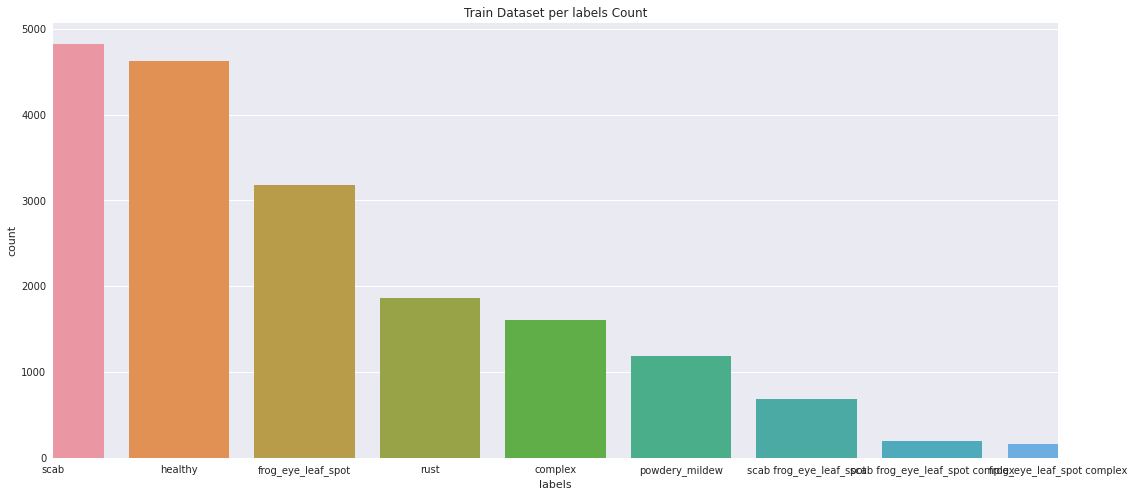

In [10]:
f,ax = plt.subplots(1,1,figsize=(18,8))
ax = sns.countplot(train_df['labels'], order=train_df['labels'].value_counts().sort_values(ascending=False).index)
ax.set_xlim(0,8)
ax.set_title('Train Dataset per labels Count')
plt.show()

In [11]:
unique_list = np.unique(train_df['labels'])
print(unique_list)
print(train_df['labels'].value_counts().count())

['complex' 'frog_eye_leaf_spot' 'frog_eye_leaf_spot complex' 'healthy'
 'powdery_mildew' 'powdery_mildew complex' 'rust' 'rust complex'
 'rust frog_eye_leaf_spot' 'scab' 'scab frog_eye_leaf_spot'
 'scab frog_eye_leaf_spot complex']
12


In [12]:
def read_image(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile, dtype = tf.float32)
    return image

In [13]:
def get_label(path):
    return_label = train_df[train_df['image']==path]['labels']
    print(return_label)
    return list(return_label)

In [14]:
def get_label_image(path):
    label = get_label(path)
    image = read_image(path)
    return label, image

10699    frog_eye_leaf_spot
Name: labels, dtype: object


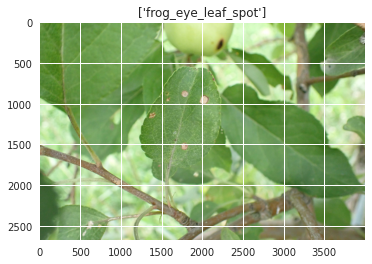

13977    scab frog_eye_leaf_spot
Name: labels, dtype: object


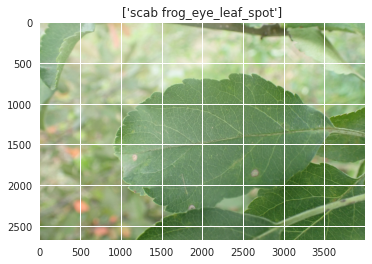

13139    frog_eye_leaf_spot complex
Name: labels, dtype: object


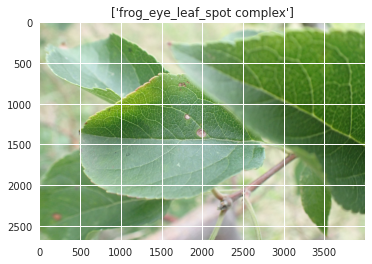

14109    complex
Name: labels, dtype: object


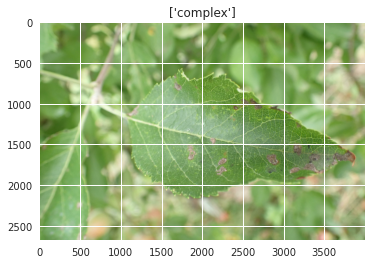

2164    scab frog_eye_leaf_spot complex
Name: labels, dtype: object


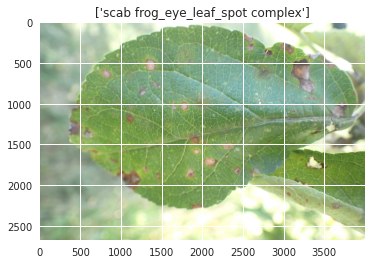

In [15]:
index_list = np.random.randint(128, size=5)
for i in index_list:
    path = datapath[i]
    sample_label, sample_image = get_label_image(path)

    plt.imshow(sample_image)
    plt.title(sample_label)
    plt.show()

# Feature Engineering
* Split Train / Validation Data
* Image Data Generate

In [16]:
INPUT_SIZE = (224,224,3)
BATCH_SIZE = 32
CLASSES = train_df['labels'].value_counts().count() # 12

In [17]:
train_data, val_data = train_test_split(train_df, test_size=0.2)
print('Train Data Shape: ',train_data.shape)
print('Test Data Shape: ',test_data.shape)

Train Data Shape:  (14905, 2)


NameError: name 'test_data' is not defined

In [18]:
train_datagen = ImageDataGenerator(
    rescale = 1/255.,
    width_shift_range = 0.3, 
    zoom_range=0.2, 
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(
    rescale = 1/255.
)

val_datagen = ImageDataGenerator(
    rescale = 1/255.
)

In [19]:
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='image',
    y_col='labels',
    target_size=INPUT_SIZE[:2],
    batch_size=BATCH_SIZE
)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='labels',
    target_size=INPUT_SIZE[:2]
)
val_generator = val_datagen.flow_from_dataframe(
    val_data,
    x_col='image',
    y_col='labels',
    target_size=INPUT_SIZE[:2],
    batch_size=BATCH_SIZE
)

Found 14905 validated image filenames belonging to 12 classes.
Found 3 validated image filenames belonging to 1 classes.
Found 3727 validated image filenames belonging to 12 classes.


In [20]:
pre_model = DenseNet121(include_top=False, weights='imagenet', input_shape=INPUT_SIZE)
pre_model.summary()

29089792/29084464 [==============================] - 1s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________

In [21]:
model = tf.keras.Sequential()
model.add(pre_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(CLASSES, activation='softmax'))

In [22]:
callback= ReduceLROnPlateau(monitor='val_loss',
                       factor=.01, 
                       patience=3, 
                       min_lr=1e-5) 

In [23]:
model.compile(optimizer =keras.optimizers.SGD(lr=0.001,momentum=.9,nesterov=False),
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

In [24]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator)//BATCH_SIZE,
    epochs=25,
    validation_data=val_generator,
    validation_steps=len(val_generator)//BATCH_SIZE,
    callbacks=[callback]
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
14/14 [==============================] - 132s 8s/step - loss: 2.6191 - accuracy: 0.1641 - val_loss: 2.1279 - val_accuracy: 0.1979
Epoch 2/25
14/14 [==============================] - 111s 8s/step - loss: 2.5501 - accuracy: 0.1816 - val_loss: 1.9435 - val_accuracy: 0.1875
Epoch 3/25
14/14 [==============================] - 112s 8s/step - loss: 2.1336 - accuracy: 0.2488 - val_loss: 2.0712 - val_accuracy: 0.2396
Epoch 4/25
14/14 [==============================] - 110s 8s/step - loss: 2.0838 - accuracy: 0.2727 - val_loss: 1.9345 - val_accuracy: 0.3125
Epoch 5/25
14/14 [==============================] - 110s 8s/step - loss: 1.9865 - accuracy: 0.2976 - val_loss: 1.7050 - val_accuracy: 0.4062
Epoch 6/25
14/14 [==============================] - 109s 8s/step - loss: 1.8997 - accuracy: 0.3511 - val_loss: 1.7528 - val_accuracy: 0.3333
Epoch 7/25
14/14 [==============================] - 109s 8s/step - loss: 1.9223 - accuracy: 0.2719 - val_loss: 1.6125 - val_accuracy: 0.4271
Epoch 8/25
14

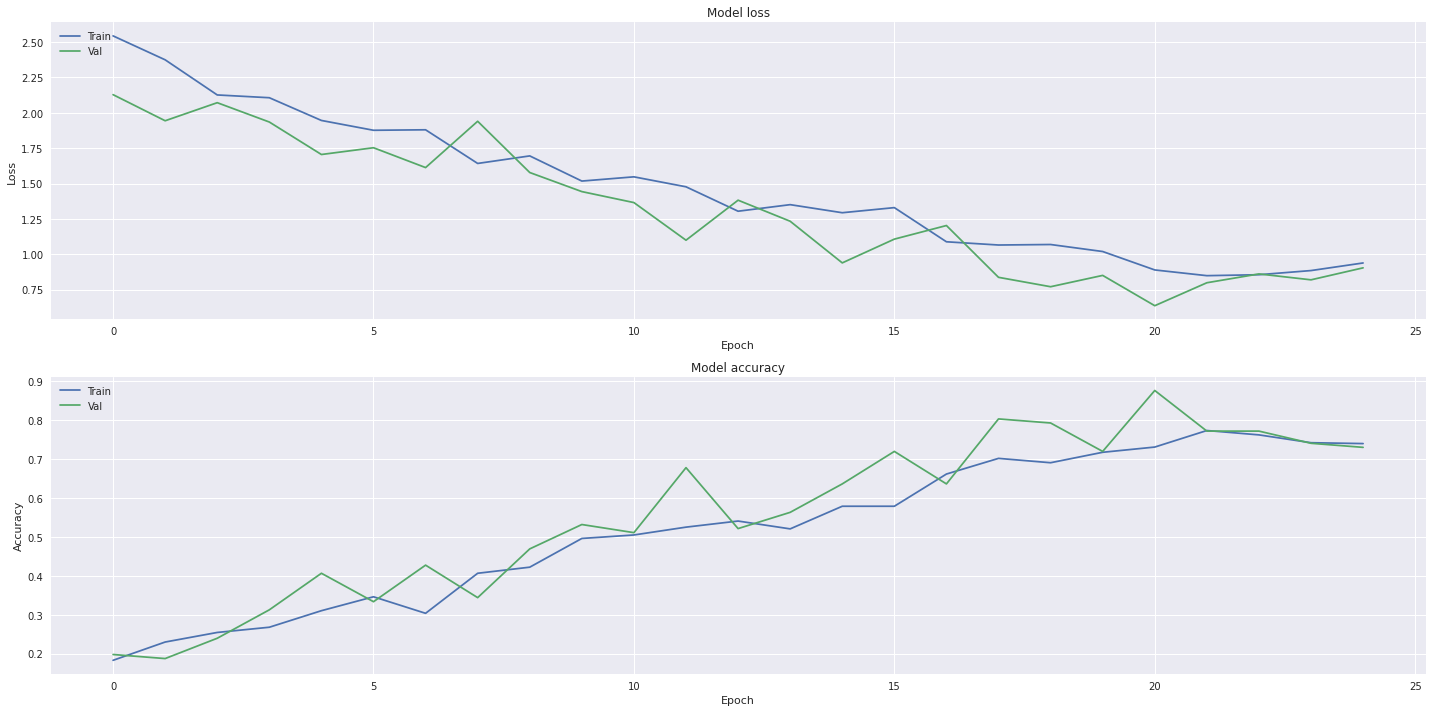

In [25]:
f,ax = plt.subplots(2,1,figsize=(20,10))
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Val'], loc='upper left')

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Val'], loc='upper left')

f.tight_layout()
plt.show()

# Submission

In [26]:
submission = pd.read_csv('/kaggle/input/plant-pathology-2021-fgvc8/sample_submission.csv')
submission.head()

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


In [27]:
preds=model.predict(test_generator)

In [28]:
test_preds = np.argmax(preds, axis=-1)
submission['labels'] = test_preds

In [29]:
submission.to_csv('submission.csv',index=False)